In [2]:
# Purpose is to assess the signal to noise ratio of each P
# across multiple trials.

import h5py
import numpy as np
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
import os

In [3]:
# Notebook default: force white background for all matplotlib figures/axes and saved files
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'white'
# Use default style to avoid dark seaborn or theme overrides
mpl.style.use('default')
# Use Plasma colormap for images and set line color cycle to Plasma colors
mpl.rcParams['image.cmap'] = 'plasma'
plasma = cm.get_cmap('plasma', 10)  # 8-color cycle from Plasma
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', [plasma(i) for i in range(plasma.N)])
print('Matplotlib defaults set: figure/axes/savefig facecolor = white; colormap=plasma')

Matplotlib defaults set: figure/axes/savefig facecolor = white; colormap=plasma


In [4]:
# Functions to remove noise from EMG signals

def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset


def bandpower_ratio(signal, fs, low=10, high=450): #changing from 20, 450
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    total_power = np.trapz(Pxx, f)
    emg_power = np.trapz(Pxx[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)])
    return emg_power / total_power

def notch_filter(data, fs, f0, Q=30.0):
    """
    Create and apply a notch filter that is compatible with both older and newer
    SciPy signatures for iirnotch.

    Newer SciPy: iirnotch(w0, Q, fs)
    Older SciPy: iirnotch(w0, Q) where w0 is normalized (0..1) relative to Nyquist.
    """
    try:
        # Try newer signature first (w0 in Hz, pass fs)
        b, a = iirnotch(f0, Q, fs)
    except TypeError:
        # Fall back to older signature: normalize f0 by Nyquist (fs/2)
        w0 = f0 / (fs / 2.0)
        b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)


def remove_odd_harmonics(data, fs, f0=50.0, harmonics=5, Q=30.0):
    filtered_data = data
    for k in range(1, harmonics + 1, 2):  # Only odd harmonics (1, 3, 5, ...)
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data


def remove_harmonics(data, fs, f0=50.0, harmonics=9, Q=30.0): #changing this from 5 to 9, bc i'm lowpassing at 450hz instead of 150hz
    filtered_data = data
    for k in range(1, harmonics + 1):  # All harmonics
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data


def feed_forward_comb_filter(signal, delay, alpha):
    """
    Apply a feed-forward comb filter to the input signal.
    Parameters:
    signal (numpy.ndarray): Input EMG signal.
    delay (int): Delay in samples. fs/freq
    alpha (float): Feedback gain factor. -1
    Returns:
    numpy.ndarray: Filtered signal.
    """
    # Initialize the output array with the same length as the input signal
    filtered_signal = np.zeros_like(signal)
    # Apply the comb filter
    for n in range(len(signal)):
        if n >= delay:
            filtered_signal[n] = signal[n] + alpha * signal[n - delay]
        else:
            filtered_signal[n] = signal[n]  # No delay possible for the initial samples
    return filtered_signal


def butter_highpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data


def butter_lowpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data


#plotting stuff 
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'white'


In [5]:
# Loading in file
#file_path = '/Users/rupshapanda/Desktop/Plasticity Lab/Null_Space_EMG/PT_07/PT_07_Day1/Coin_Task/Raw_emg_1.hdf5'  # Path to your HDF5 file
#file_path = '/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_1.hdf5'
file_path ='/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day1/PT_11_1_2025_04_28/EMG_Calibration/Raw_emg_1.hdf5'
dataset_name = 'rawEMG'
hdf5_file, dataset = open_hdf5_file(file_path, dataset_name, mode='r')
data = np.array(dataset[:])

#create an empty .csv file that has Subject ID, Day #, Task, Trial #, Channel #, SNR, RMS, muscle group

# assign variables
fs = 2000  # Hz
freq = 50
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor
highpass_filt = 10
lowpass_filt = 450

# Ordering channel based on muscle groups
# if its from PT_07 to PT_15:
flexors = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8]
extensors = [57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53]
bicep = [22,21,20,19,18,17,25,26,27,28,29,30]
lateral_tri = [40,32,38,36,31,39,37,35] 
long_tri = [47,46,45,49,48,52,51,50]

# Define your desired order (all 64 electrodes in the order you want)
desired_order = flexors + extensors + bicep + lateral_tri + long_tri

# Reorder columns - Python uses 0-based indexing, so subtract 1
reordered_x = data[:, [e-1 for e in desired_order]]

In [ ]:
# # Ordering channel based on muscle groups
# # # if its from PT_07 to PT_15:

# flexors = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8]
# extensors = [57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53]
# bicep = [22,21,20,19,18,17,25,26,27,28,29,30]
# lateral_tri = [40,32,38,36,31,39,37,35] 
# long_tri = [47,46,45,49,48,52,51,50]

# # # if it's from PT_16 to PT_21
# # # need to split differently 
# # flexors = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10] # the 8 is renamed to 10 bc sensors have 2 8s
# # extensors = [11,12,13,14,15,16,1,2,3,4,5,6,7,52,8,49,50,51]
# # bicep = [40,39,38,37,36,35,34,33,48,47,46,45]
# # lateral_tri = [42,43,41,56,47,55,54,53]
# # long_tri = [62,63,64,60,61,57,58,59]


# # Define your desired order (all 64 electrodes in the order you want)
# desired_order = flexors + extensors + bicep + lateral_tri + long_tri

# # Reorder columns - Python uses 0-based indexing, so subtract 1
# reordered_x = data[:, [e-1 for e in desired_order]]
# # electrode_mapping = {new_idx: original_electrode 
# #                      for new_idx, original_electrode in enumerate(desired_order)}
# # print("Electrode mapping (new index -> original electrode):")   
# # for new_idx, original_electrode in electrode_mapping.items():
# #     print(f"{new_idx}:{original_electrode}")

In [6]:
# for each channel, perform these filters across 2000hz
filtered_x = np.zeros_like(data)
for i in range(64):
    #ax = plt.subplot(8, 8, i+1)
    x_data = data[:, i]
    x_data = butter_highpass(x_data, highpass_filt, 2000) # 10 is the freq we're taking out over the 2000 hz signal
    x_data = butter_lowpass(x_data, lowpass_filt, 2000)
    # data = feed_forward_comb_filter(data, delay, alpha)
    x_data = remove_harmonics(x_data,2000)
    filtered_x[:,i] = x_data

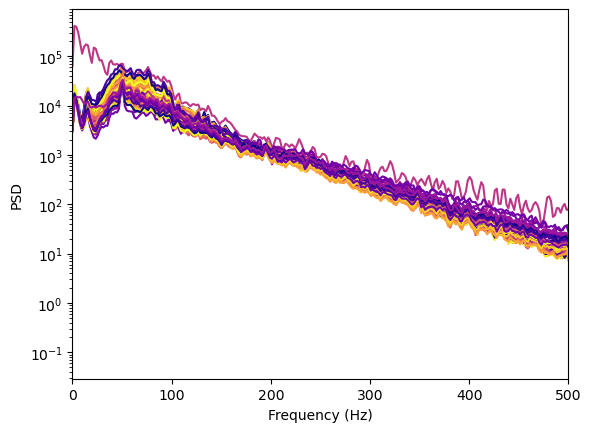

In [7]:
fs = 2000  # Hz
for i in range(64):
    f, Pxx = welch(data[:, i], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx)
    plt.xlim([0, 500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

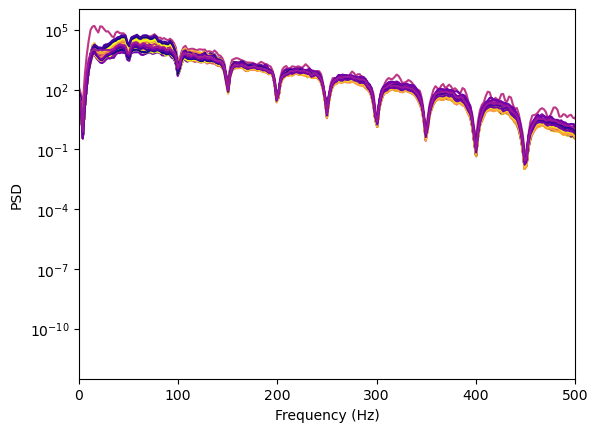

In [8]:
fs = 2000  # Hz
for i in range(64):
    f, Pxx = welch(filtered_x[:, i], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx)
    plt.xlim([0, 500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

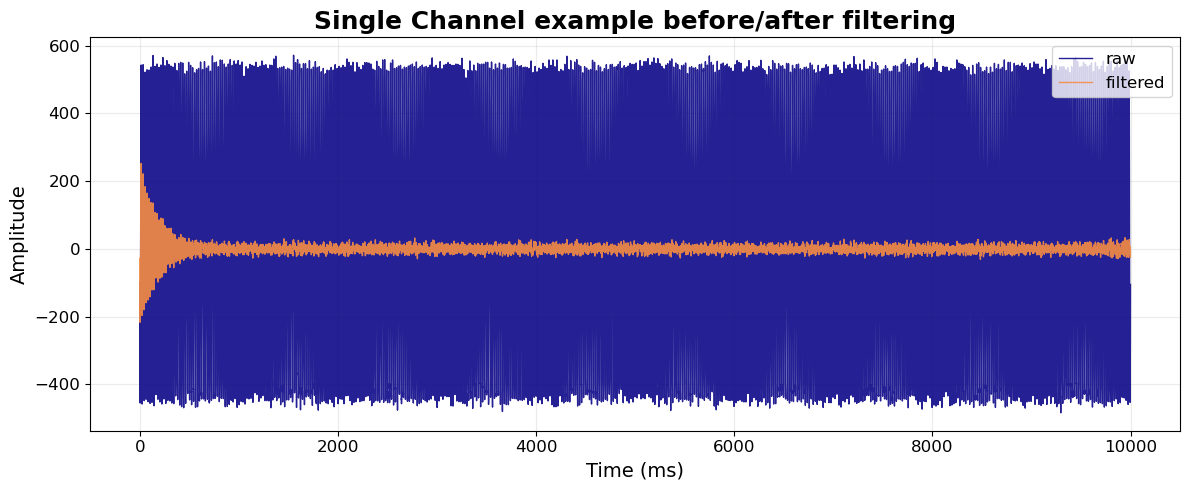

In [13]:
# Single-channel overlapped raw vs filtered
# choose channel and plot first 5000 samples (~2.5 s at fs=2000)
ch = 37
x = data[:, ch]
# apply filters to this channel (ensure we pass the filtered signal between stages)
x_f = butter_highpass(x, highpass_filt, fs)
x_f = butter_lowpass(x_f, lowpass_filt, fs)
x_f = remove_harmonics(x_f, fs)
#x_f = bandpower_ratio(x_f, fs)

# time axis in ms for plotting
n_plot = min(20000, x.shape[0])
t = np.arange(n_plot) / fs * 1000.0

# pick two distinct Plasma colors (and reserve two extra if you need them)
from matplotlib import cm
cmap = cm.get_cmap('plasma', 12)
raw_color = cmap(0)
filtered_color = cmap(8)
extra_color1 = cmap(5)
extra_color2 = cmap(11)

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.plot(t, x[:n_plot], color=raw_color, linewidth=1, alpha=0.9, label='raw')
ax.plot(t, x_f[:n_plot], color=filtered_color, linewidth=1, alpha=0.9, label='filtered')

# styling
ax.set_title('Single Channel example before/after filtering', fontsize=18, weight='bold')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(alpha=0.25)
leg = ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

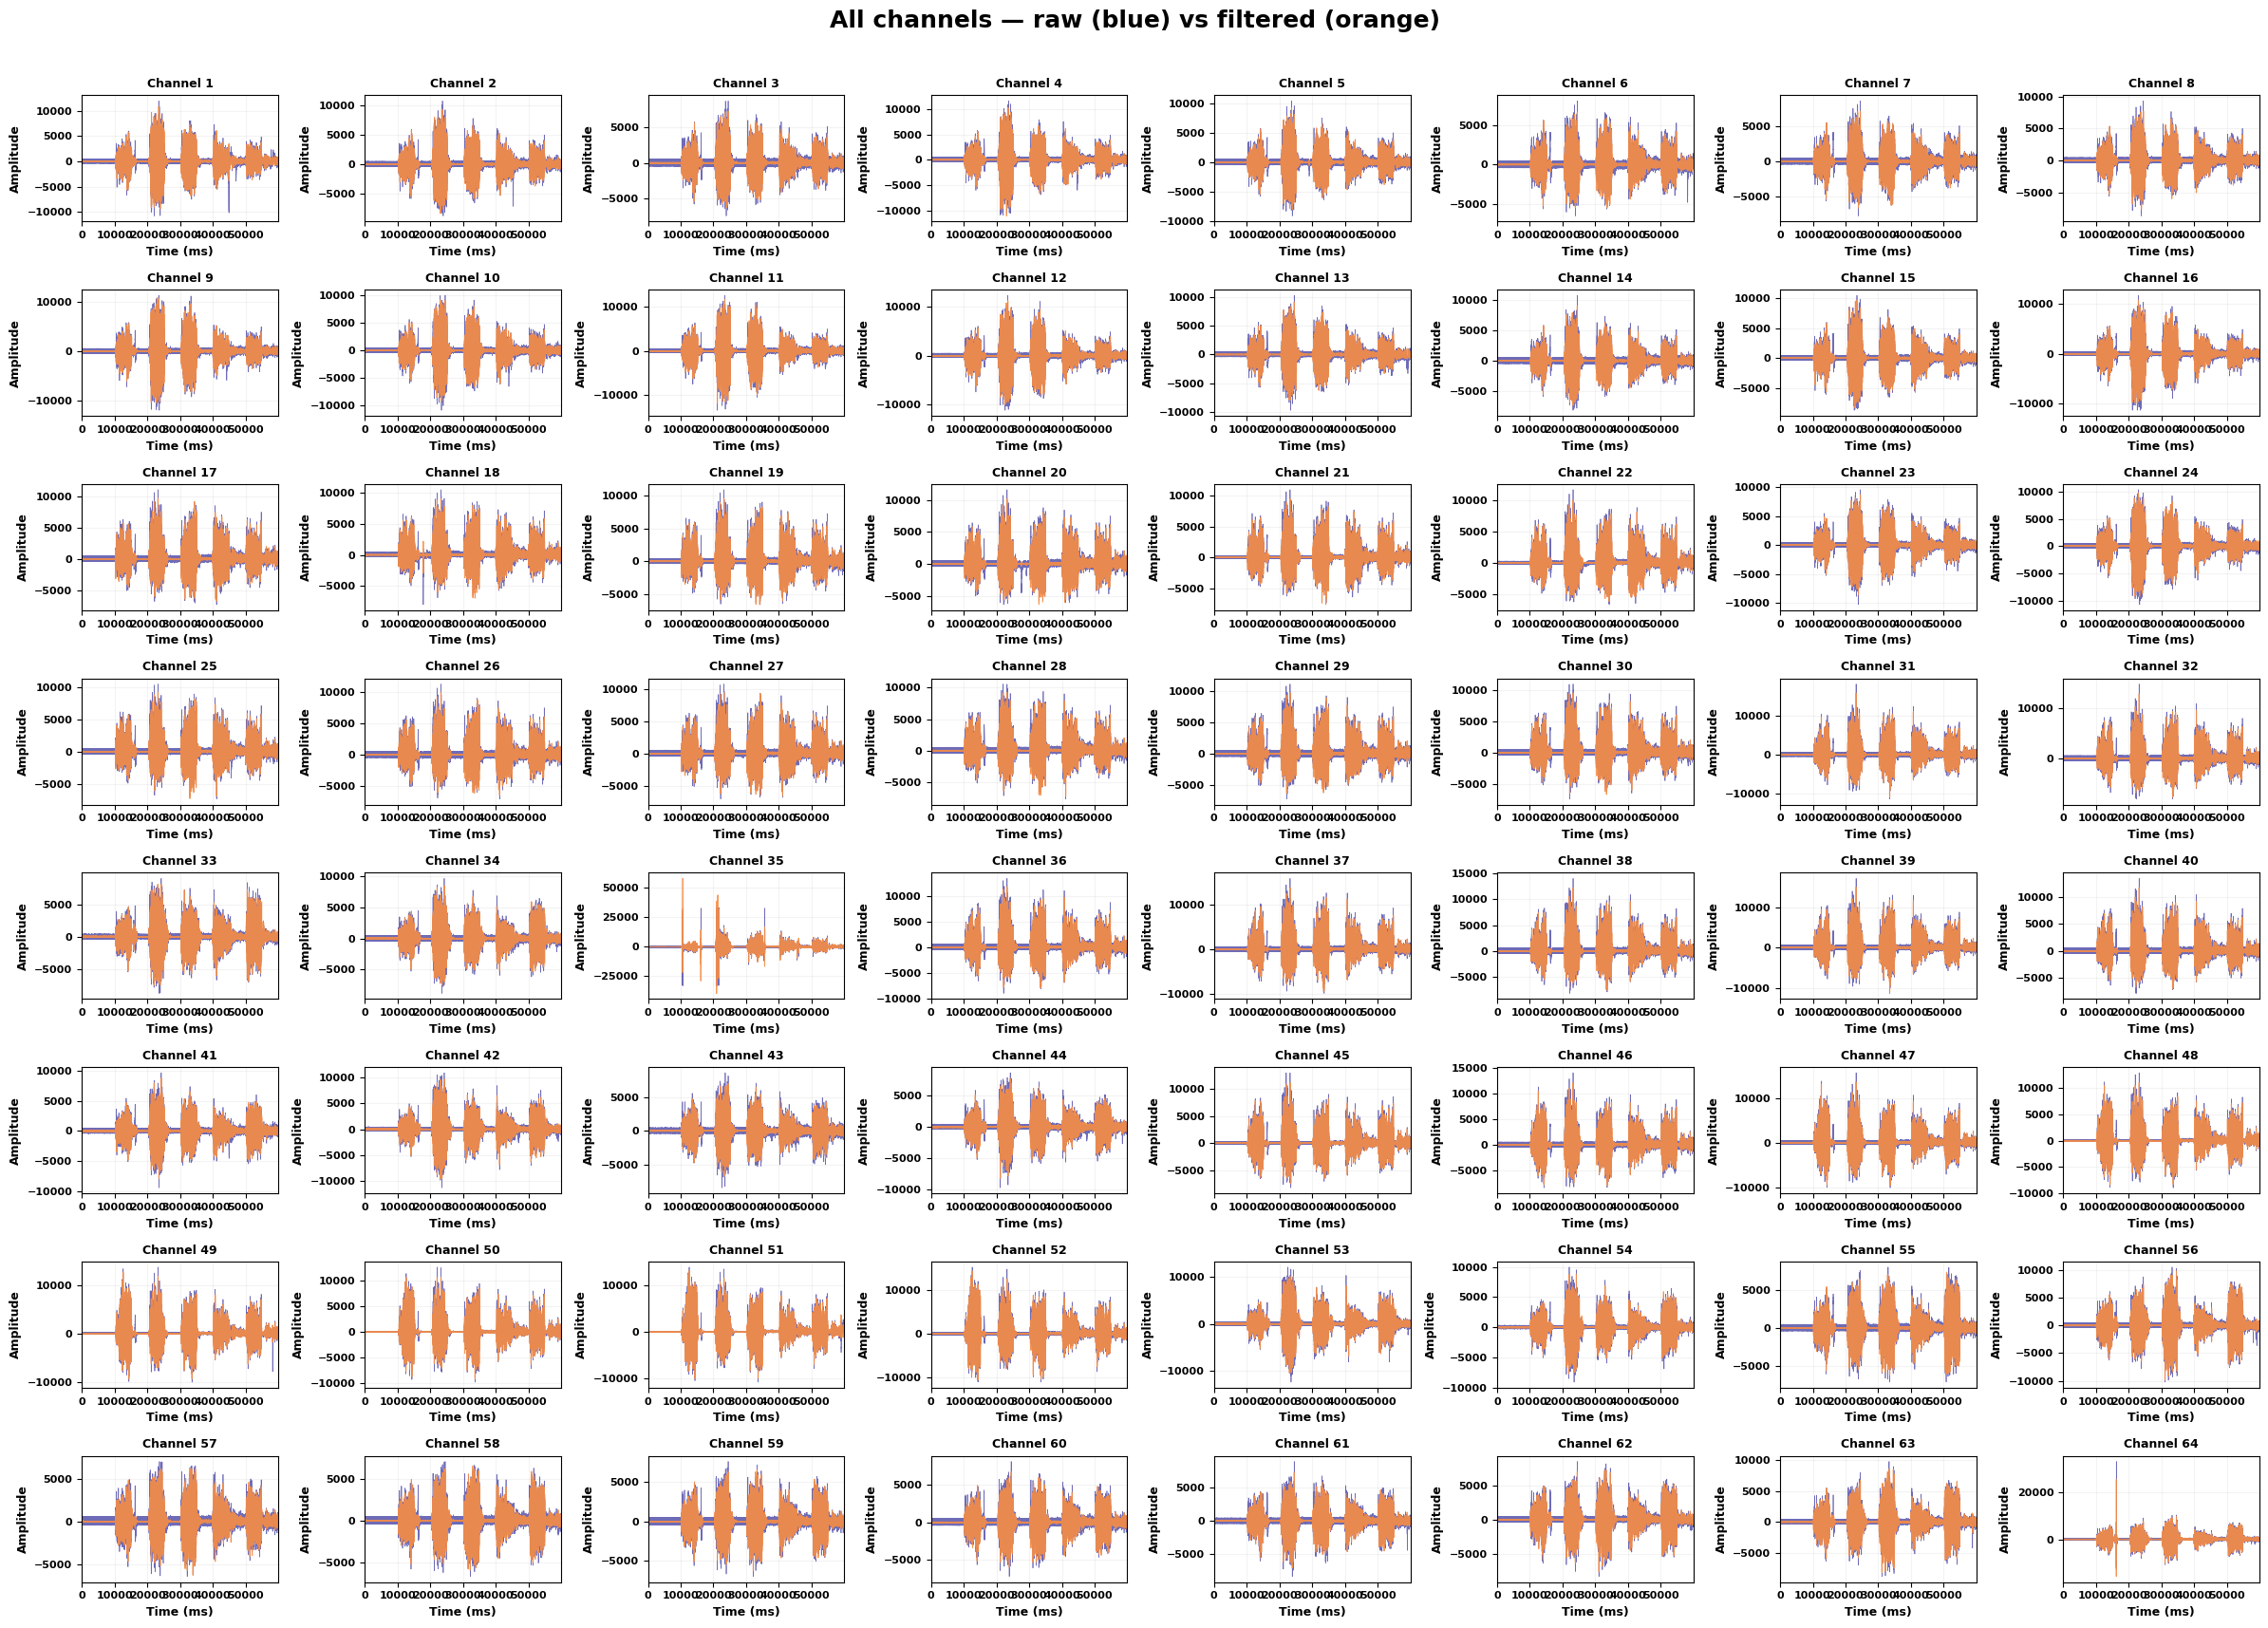

In [14]:
# 8x8 overlapped time-domain plots (raw vs filtered) — first ~2.5s
# This will create a single figure with 64 subplots arranged 8x8,
# each showing raw (faint) and filtered (solid) traces for the first 5000 samples.
from matplotlib import cm
cmap = cm.get_cmap('plasma', 12)
raw_color = cmap(0)
filtered_color = cmap(8)
n_plot = min(120000, data.shape[0])
plt.figure(figsize=(24, 18))
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    # extract channel (handles both shapes: samples x channels or channels x samples)
    if data.shape[0] == 64 and data.shape[1] != 64:
        x = data[i, :]
    else:
        x = data[:, i]
    # compute filtered version for plotting (keep it fast by operating on 1D arrays)
    x_f = butter_highpass(x, highpass_filt, fs)
    x_f = butter_lowpass(x_f, lowpass_filt, fs)
    x_f = remove_harmonics(x_f, fs)
    t = np.arange(n_plot) / fs * 1000.0  # ms
    ax.plot(t, x[:n_plot], color=raw_color, linewidth=0.5, alpha=0.6)
    ax.plot(t, x_f[:n_plot], color=filtered_color, linewidth=0.8, alpha=0.9)
    ax.set_title(f'Channel {i+1}', fontsize=9, fontweight='bold')
    ax.set_xlabel('Time (ms)', fontsize=9, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=9, fontweight='bold')
    ax.set_xlim(t[0], t[-1])
    ax.tick_params(axis='both', labelsize=8)
    # make tick labels a bit bolder
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    ax.grid(alpha=0.15)
plt.suptitle('All channels — raw (blue) vs filtered (orange)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

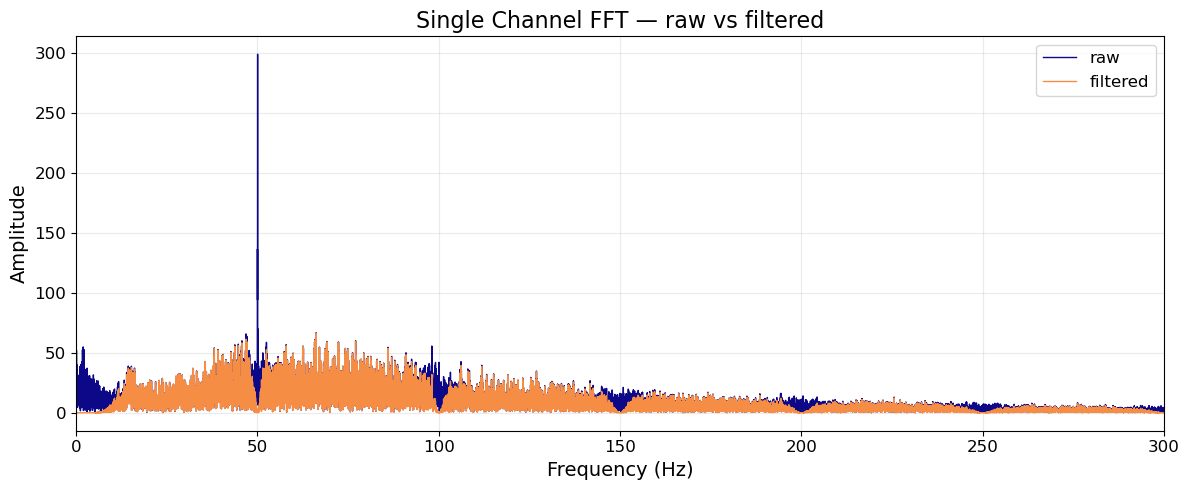

In [12]:
# Single-channel FFT example: raw vs filtered (single-sided amplitude)
ch = 37
x = data[:, ch]
# compute filtered version again to be safe
x_f = butter_highpass(x, highpass_filt, fs)
x_f = butter_lowpass(x_f, lowpass_filt, fs)
x_f = remove_harmonics(x_f, fs)

n = len(x)
# FFTs
yf = np.fft.fft(x)
yf_f = np.fft.fft(x_f)
xf = np.fft.fftfreq(n, 1.0/fs)

# single-sided amplitude (proper scaling)
amp = np.abs(yf) / n
amp_f = np.abs(yf_f) / n

# double the positive frequencies (except DC and Nyquist if present)
mask = xf >= 0
amp_ss = amp.copy()
amp_f_ss = amp_f.copy()
amp_ss[mask] = amp[mask] * 2.0
amp_f_ss[mask] = amp_f[mask] * 2.0
amp_ss[0] = amp[0]
amp_f_ss[0] = amp_f[0]
if n % 2 == 0:
    nyq = n // 2
    amp_ss[nyq] = amp[nyq]
    amp_f_ss[nyq] = amp_f[nyq]

xf_pos = xf[mask]
amp_pos = amp_ss[mask]
amp_f_pos = amp_f_ss[mask]

# colors from Plasma
from matplotlib import cm
cmap = cm.get_cmap('plasma', 12)
raw_color = cmap(0)
filtered_color = cmap(8)

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.plot(xf_pos, amp_pos, color=raw_color, linewidth=1, label='raw')
ax.plot(xf_pos, amp_f_pos, color=filtered_color, linewidth=1, label='filtered')

ax.set_xlim(0, 300)
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('Single Channel FFT — raw vs filtered', fontsize=16)
ax.grid(alpha=0.25)
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()


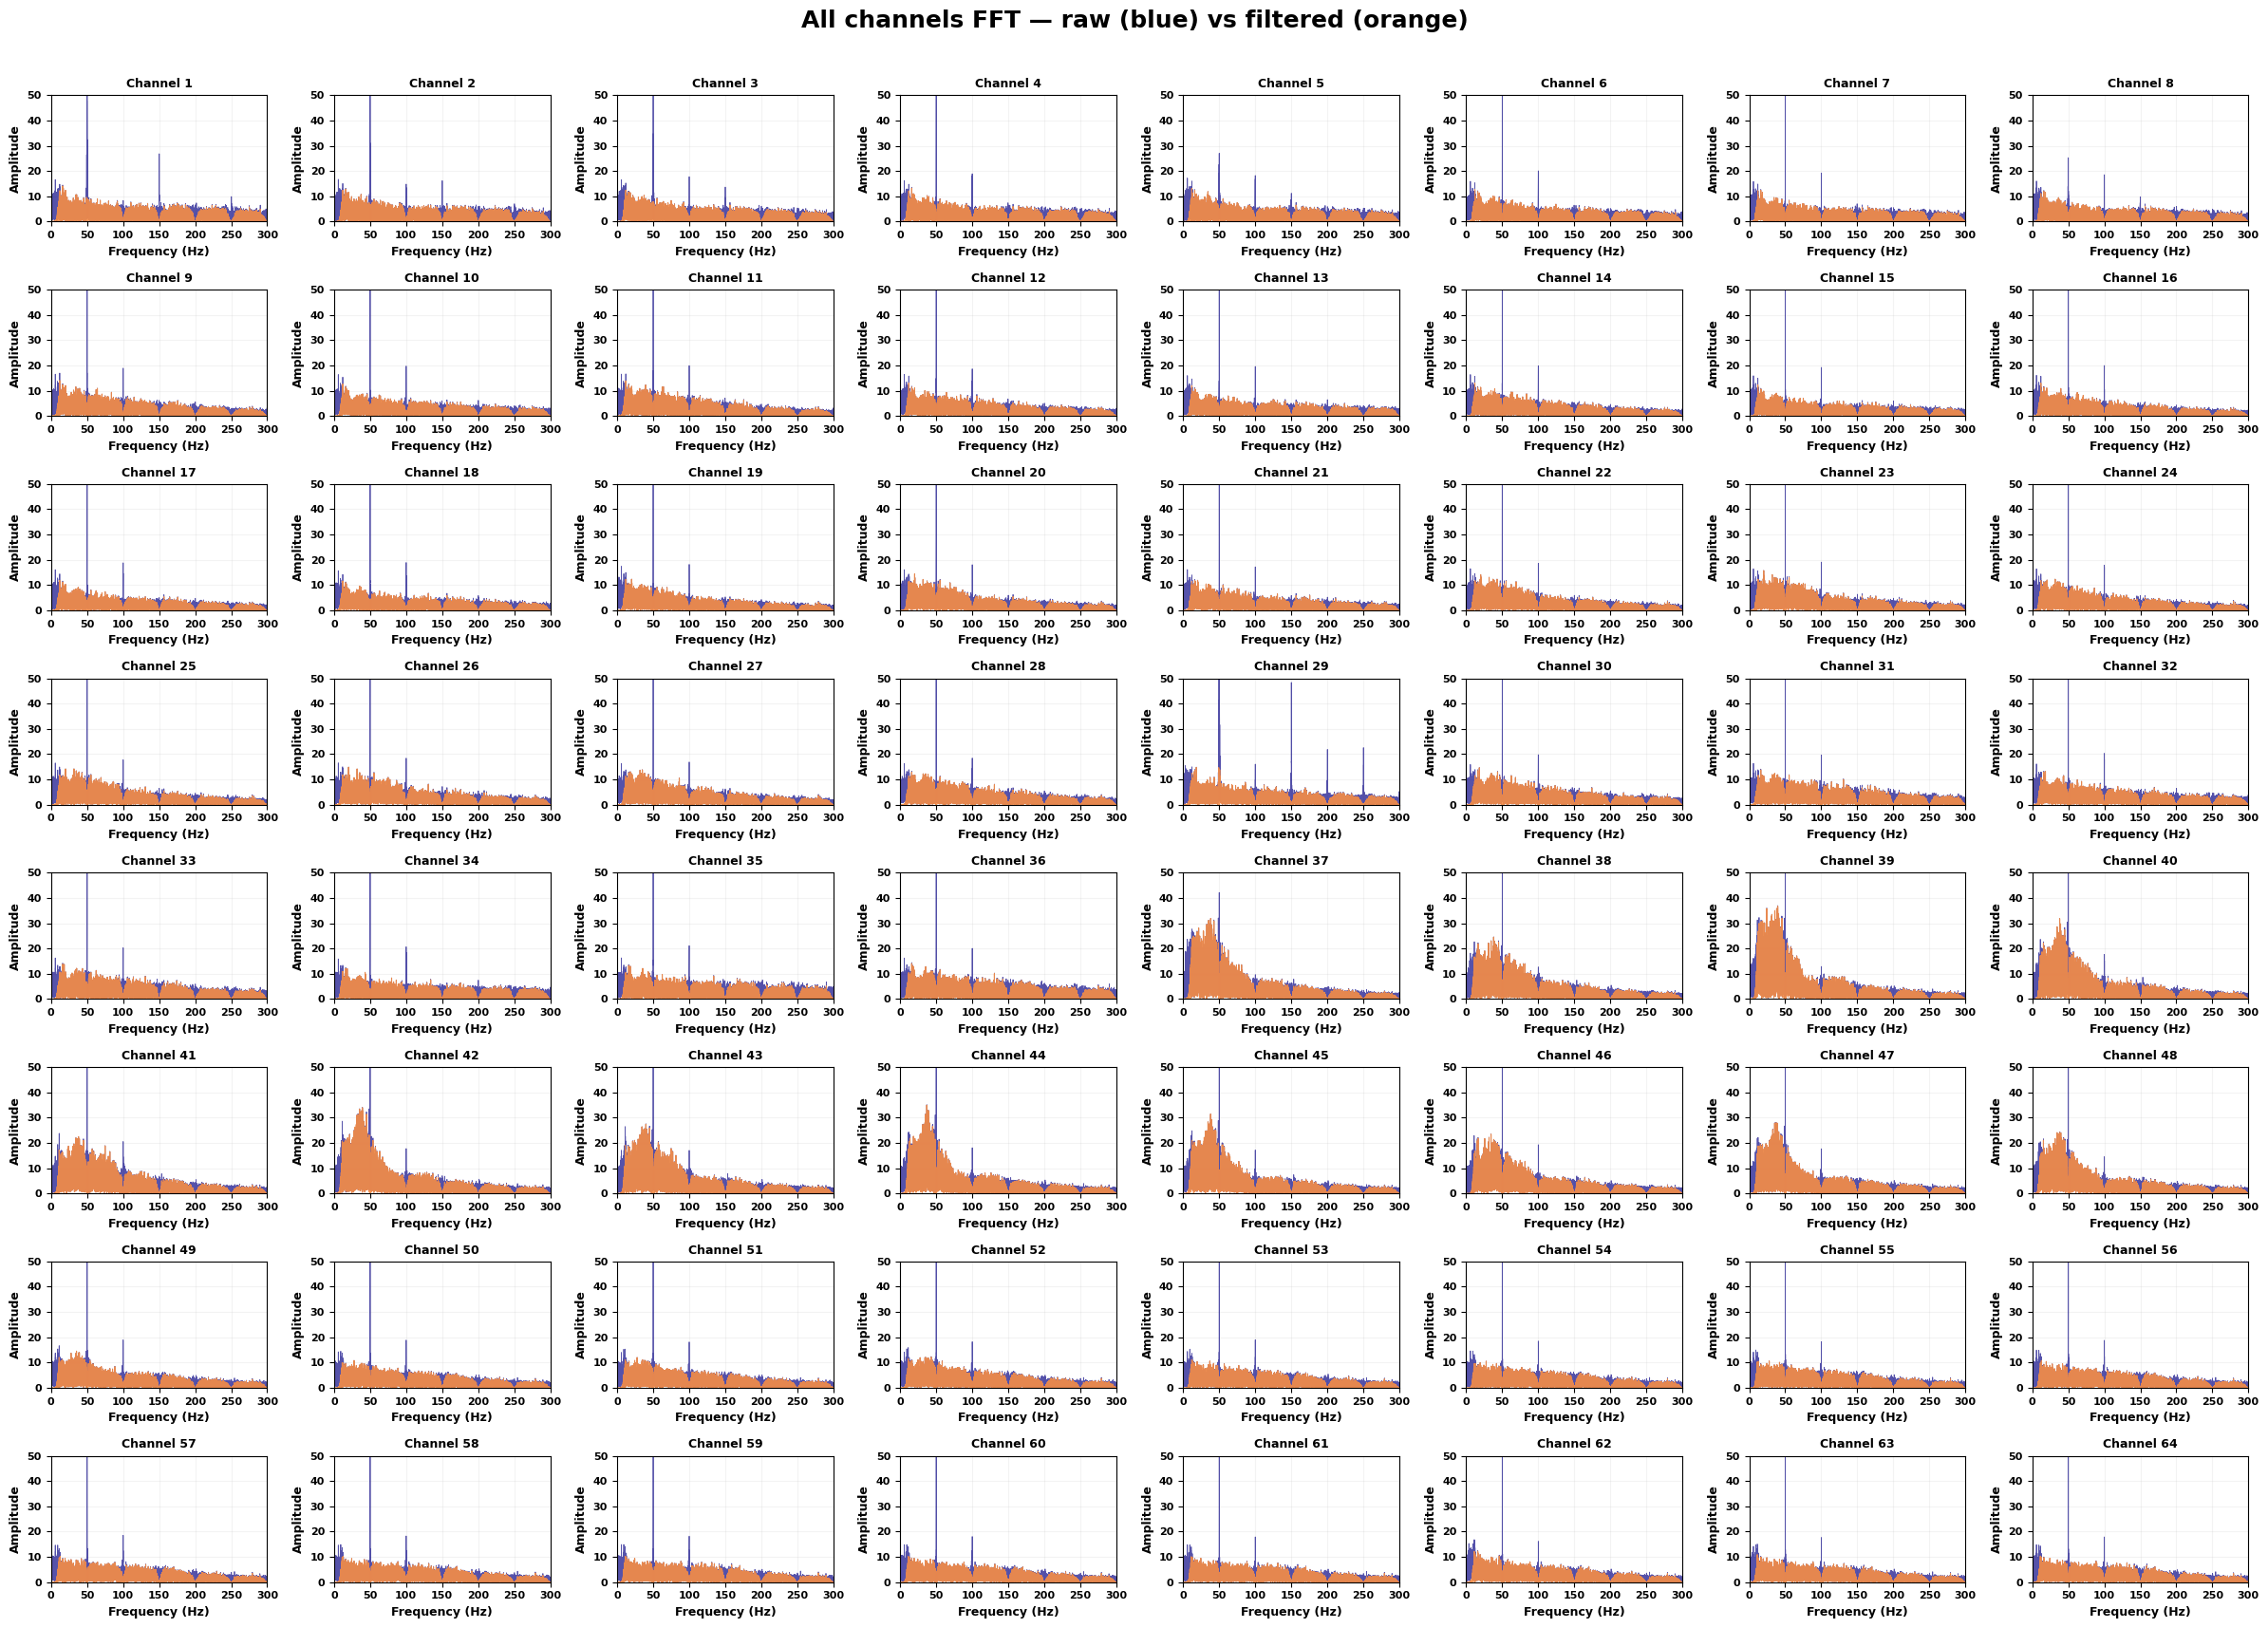

In [31]:
# 8x8 FFT amplitude plots (single-sided) — raw vs filtered
# Plots single-sided amplitude spectra for each channel from 0..300 Hz
from matplotlib import cm
cmap = cm.get_cmap('plasma', 12)
raw_color = cmap(0)
filtered_color = cmap(8)
plt.figure(figsize=(24, 18))
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    # extract channel (handle possible transposed shapes)
    if data.shape[0] == 64 and data.shape[1] != 64:
        x = data[i, :]
    else:
        x = data[:, i]
    # filtered signal
    x_f = butter_highpass(x, highpass_filt, fs)
    x_f = butter_lowpass(x_f, lowpass_filt, fs)
    x_f = remove_harmonics(x_f, fs)
    n = len(x)
    yf = np.fft.fft(x)
    yf_f = np.fft.fft(x_f)
    xf = np.fft.fftfreq(n, 1.0/fs)
    mask = xf >= 0
    amp = np.abs(yf) / n
    amp_f = np.abs(yf_f) / n
    amp_ss = amp.copy()
    amp_f_ss = amp_f.copy()
    amp_ss[mask] = amp[mask] * 2.0
    amp_f_ss[mask] = amp_f[mask] * 2.0
    amp_ss[0] = amp[0]
    amp_f_ss[0] = amp_f[0]
    if n % 2 == 0:
        nyq = n // 2
        amp_ss[nyq] = amp[nyq]
        amp_f_ss[nyq] = amp_f[nyq]
    xf_pos = xf[mask]
    amp_pos = amp_ss[mask]
    amp_f_pos = amp_f_ss[mask]
    ax.plot(xf_pos, amp_pos, color=raw_color, linewidth=0.6, alpha=0.7)
    ax.plot(xf_pos, amp_f_pos, color=filtered_color, linewidth=0.8, alpha=0.9)
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 50)
    ax.set_title(f'Channel {i+1}', fontsize=9, fontweight='bold')
    ax.set_xlabel('Frequency (Hz)', fontsize=9, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=9, fontweight='bold')
    ax.tick_params(axis='both', labelsize=8)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    ax.grid(alpha=0.15)
plt.suptitle('All channels FFT — raw (blue) vs filtered (orange)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [35]:
# Signal to Noise Ratio
snr_estimates_filtered = [bandpower_ratio(filtered_x[:, i], fs) for i in range(64)]
print("SNR estimate per channel:", snr_estimates_filtered)

# Mean Signal to Noise Ratio
mean_snr_estimates_filtered = np.mean([bandpower_ratio(filtered_x[:, i], fs) for i in range(64)])
print("Mean SNR estimate:", np.mean(mean_snr_estimates_filtered))

# Assessing channels that have SNR less than 0.6
low_snr_idx = np.where(np.array(snr_estimates_filtered) < 0.6)[0]
print("Channels with SNR < 0.6:", low_snr_idx)

SNR estimate per channel: [0.9772301061678206, 0.9759241195736412, 0.9723332369256279, 0.9754045744971823, 0.9716676670708073, 0.9743176258993667, 0.9731889808984444, 0.9715170514090956, 0.9765951219070772, 0.9719923824516131, 0.9785489503393966, 0.9741920919000157, 0.9710593495033668, 0.973997664364966, 0.9696045632391943, 0.9725226120757112, 0.9692031350358351, 0.9703229083568838, 0.971456077942122, 0.9771879125939437, 0.9743703366706381, 0.979016297891201, 0.9809041273116967, 0.9774926909013192, 0.9804226017114163, 0.9805064087604194, 0.98082752334147, 0.9805787270015702, 0.9716962325662245, 0.9799546362587768, 0.982715036406921, 0.9768746416711676, 0.9820943079997062, 0.9749091667428641, 0.9814840703384691, 0.9831382936801601, 0.9770970695379504, 0.9814020679625856, 0.9801431424770046, 0.9843185955447772, 0.9848950055566349, 0.9834366882105608, 0.9847731321289013, 0.9843701130961099, 0.9839848311709898, 0.9814982452359869, 0.9825416250502517, 0.9806395995311079, 0.978025724817453, 

In [36]:
# Calculate RMS per channel
rms_channels = np.sqrt(np.mean(filtered_x**2, axis=0))
print("RMS per channel:", rms_channels)

# Z-score the RMS values
rms_z = (rms_channels - np.mean(rms_channels)) / np.std(rms_channels)
print(rms_z)

# Find indices of outliers
outlier_idx = np.where((rms_z > 3) | (rms_z < -3))[0]
print("Outlier channels (|z| > 3):", outlier_idx)

# Remove those channels from filtered_x and RMS arrays
filtered_x_clean = np.delete(filtered_x, outlier_idx, axis=1)
rms_clean = np.delete(rms_channels, outlier_idx)

RMS per channel: [262.12466 248.808   240.91476 233.20181 232.1629  221.92123 216.96213
 212.26726 240.58868 211.94167 248.30739 224.46658 205.49487 220.2515
 198.99959 210.0617  196.56299 199.95421 215.87518 241.55824 218.64954
 250.86856 269.19    234.26273 261.8943  262.72586 256.684   255.56346
 239.81866 255.20651 272.4058  237.52982 271.12613 234.07712 272.64752
 282.51047 474.39853 388.9735  534.4051  435.26907 383.8721  477.2958
 427.78778 454.0332  421.53387 365.84396 397.51312 372.01526 257.10373
 226.76582 239.71622 252.16818 229.22713 224.83974 232.82516 224.47221
 222.91028 223.45184 224.38211 221.528   221.6763  229.80336 222.1013
 221.08298]
[-1.14687257e-01 -2.80748308e-01 -3.79178256e-01 -4.75360066e-01
 -4.88315463e-01 -6.16030753e-01 -6.77871644e-01 -7.36417472e-01
 -3.83244544e-01 -7.40477681e-01 -2.86991000e-01 -5.84289849e-01
 -8.20870280e-01 -6.36852682e-01 -9.01867568e-01 -7.63921082e-01
 -9.32252347e-01 -8.89963269e-01 -6.91426039e-01 -3.71153980e-01
 -6.568294

In [ ]:
# Raw data with x = Time, y = Amplitude
# absolute value of the data
# do envelop on the abs value
# this is after doing the most basic filtering
# this is what you do for feature extractions
plt.figure(figsize=(24, 12))
data_abs=np.abs(data)
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.plot(data_abs[:5000, i])  # first 2.5 sec (5000 samples at 2kHz)
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
# FFT plots for each channel
plt.figure(figsize=(24, 12))

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    x_data = data[:, i]
    yf = np.fft.fft(x_data)
    xf = np.fft.fftfreq(len(x_data), 1/2000)
    ax.plot(xf, np.abs(yf))
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(0,200)

plt.tight_layout()
plt.show()


In [ ]:
# FFT plots after filtering for each channel using bandpass and harmonic removal
plt.figure(figsize=(24, 12))
freq = 50
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    x_data = data[:, i]
    x_data = butter_highpass(x_data, 10, 2000) # 10 is the freq we're taking out over the 2000 hz signal
    x_data = butter_lowpass(x_data, 150, 2000)
    # data = feed_forward_comb_filter(data, delay, alpha)
    x_data = remove_harmonics(x_data,2000)
    yf = np.fft.fft(x_data)
    xf = np.fft.fftfreq(len(x_data), 1/2000)
    ax.plot(xf, np.abs(yf))
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(0,500)

plt.tight_layout()
plt.show()

In [ ]:
# Force white backgrounds for figure, axes, and saved files
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'white'

plt.figure(figsize=(24, 12))
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    data = butter_highpass(data,10,2000)
    ax.plot(data[:5000, i])  # first 2.5 sec (5000 samples at 2kHz)
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [30]:
def EMGfilter(data, SampleFreq, BandpassLowFreq, BandpassHighFreq, EnvelopeFreq, order):
    Cf = (np.sqrt(2)-1)**(1/(2*order))
    Wn_bp = np.array([BandpassLowFreq, BandpassHighFreq]) * 2 / SampleFreq / Cf
    Wn_lp = EnvelopeFreq * 2 / SampleFreq / Cf
    # use scipy.signal namespace because butter/lfilter/iirfilter were not imported into the global namespace
    b, a = scipy.signal.butter(order, Wn_bp, btype='band')
    emg_bp = scipy.signal.lfilter(b, a, data.T)
    iirFilt = scipy.signal.iirfilter(2, [48, 52], rs=20, btype='bandstop', analog=False, ftype='butter', fs=SampleFreq)
    emg_bs = filtfilt(iirFilt[0], iirFilt[1], emg_bp)
    rect_emg = np.abs(emg_bs)
    #b_lp, a_lp = scipy.signal.butter(order, Wn_lp, btype='low')
    #emg_filt = scipy.signal.lfilter(b_lp, a_lp, rect_emg)
    #emg_filt = emg_filt.T
    #return emg_filt
    return emg_bs.T